# Performing parallel / batch processing of simulations

<img src="img/splitter.png" alt="diagram" width="400"/>

Note: the cost of running the entire notebook is larger than 1 FlexCredit.

In this notebook, we will show an example of using tidy3d to evaluate device performance over a set of many design parameters.

This example will also provide a walkthrough of Tidy3D's [Job](../_autosummary/tidy3d.web.Job.html) and [Batch](../_autosummary/tidy3d.web.Batch.html) features for managing both individual simulations and sets of simulations.

> Note: as of version `1.8`, the [tidy3d.web.run_async](../_autosummary/tidy3d.web.run_async.html) function handles the same functionality as the batch, with a simpler syntax. As such, it could be a good alternative for parameter scan depending on how your script is set up.

For demonstration, we look at the splitting ratio of a directional coupler as we vary the coupling length between two waveguides. The sidewall of the waveguides is slanted, deviating from the vertical direction by `sidewall_angle`.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import os
import gdstk

# tidy3D imports
import tidy3d as td
from tidy3d import web


## Setup

First we set up some global parameters

In [2]:
# wavelength / frequency
lambda0 = 1.550  # all length scales in microns
freq0 = td.constants.C_0 / lambda0
fwidth = freq0 / 10

# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
mat_wg = td.Medium(permittivity=wg_n**2)
mat_sub = td.Medium(permittivity=sub_n**2)

# Waveguide dimensions

# Waveguide height
wg_height = 0.22
# Waveguide width
wg_width = 0.45
# Waveguide separation in the beginning/end
wg_spacing_in = 8
# Reference plane where the cross section of the device is defined
reference_plane = "bottom"
# Angle of the sidewall deviating from the vertical ones, positive values for the base larger than the top
sidewall_angle = np.pi / 6
# Total device length along propagation direction
device_length = 100
# Length of the bend region
bend_length = 16
# space between waveguide and PML
pml_spacing = 1
# resolution control: minimum number of grid cells per wavelength in each material
grid_cells_per_wvl = 16


### Define waveguide bends and coupler

Here is where we define our directional coupler shape programmatically in terms of the geometric parameters

In [3]:
def tanh_interp(max_arg):
    """Interpolator for tanh with adjustable extension"""
    scale = 1 / np.tanh(max_arg)
    return lambda u: 0.5 * (1 + scale * np.tanh(max_arg * (u * 2 - 1)))


def make_coupler(
    length,
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length,
    npts_bend=30,
):
    """Make an integrated coupler using the gdstk RobustPath object."""
    # bend interpolator
    interp = tanh_interp(3)
    delta = wg_width + wg_spacing_coup - wg_spacing_in
    offset = lambda u: wg_spacing_in + interp(u) * delta

    coup = gdstk.RobustPath(
        (-0.5 * length, 0),
        (wg_width, wg_width),
        wg_spacing_in,
        simple_path=True,
        layer=1,
        datatype=[0, 1],
    )
    coup.segment((-0.5 * coup_length - bend_length, 0))
    coup.segment(
        (-0.5 * coup_length, 0),
        offset=[lambda u: -0.5 * offset(u), lambda u: 0.5 * offset(u)],
    )
    coup.segment((0.5 * coup_length, 0))
    coup.segment(
        (0.5 * coup_length + bend_length, 0),
        offset=[lambda u: -0.5 * offset(1 - u), lambda u: 0.5 * offset(1 - u)],
    )
    coup.segment((0.5 * length, 0))
    return coup


### Create Simulation and Submit Job

The following function creates a tidy3d simulation object for a set of design parameters.

Note that the simulation has not been run yet, just created.

In [4]:
def make_sim(coup_length, wg_spacing_coup, domain_field=False):
    """Make a simulation with a given length of the coupling region and
    distance between the waveguides in that region. If ``domain_field``
    is True, a 2D in-plane field monitor will be added.
    """

    # Geometry must be placed in GDS cells to import into Tidy3D
    coup_cell = gdstk.Cell("Coupler")

    substrate = gdstk.rectangle(
        (-device_length / 2, -wg_spacing_in / 2 - 10),
        (device_length / 2, wg_spacing_in / 2 + 10),
        layer=0,
    )
    coup_cell.add(substrate)

    # Add the coupler to a gdstk cell
    gds_coup = make_coupler(
        device_length,
        wg_spacing_in,
        wg_width,
        wg_spacing_coup,
        coup_length,
        bend_length,
    )
    coup_cell.add(gds_coup)

    # Substrate
    (oxide_geo,) = td.PolySlab.from_gds(
        gds_cell=coup_cell,
        gds_layer=0,
        gds_dtype=0,
        slab_bounds=(-10, 0),
        reference_plane=reference_plane,
        axis=2,
    )

    oxide = td.Structure(geometry=oxide_geo, medium=mat_sub)

    # Waveguides (import all datatypes if gds_dtype not specified)
    coupler1_geo, coupler2_geo = td.PolySlab.from_gds(
        gds_cell=coup_cell,
        gds_layer=1,
        slab_bounds=(0, wg_height),
        sidewall_angle=sidewall_angle,
        reference_plane=reference_plane,
        axis=2,
    )

    coupler1 = td.Structure(geometry=coupler1_geo, medium=mat_wg)

    coupler2 = td.Structure(geometry=coupler2_geo, medium=mat_wg)

    # Simulation size along propagation direction
    sim_length = 2 + 2 * bend_length + coup_length

    # Spacing between waveguides and PML
    sim_size = [
        sim_length,
        wg_spacing_in + wg_width + 2 * pml_spacing,
        wg_height + 2 * pml_spacing,
    ]

    # source
    src_pos = -sim_length / 2 + 0.5
    msource = td.ModeSource(
        center=[src_pos, wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=td.ModeSpec(),
        mode_index=0,
    )

    mon_in = td.ModeMonitor(
        center=[(src_pos + 0.5), wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        mode_spec=td.ModeSpec(),
        name="in",
    )
    mon_ref_bot = td.ModeMonitor(
        center=[(src_pos + 0.5), -wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        mode_spec=td.ModeSpec(),
        name="refect_bottom",
    )
    mon_top = td.ModeMonitor(
        center=[-(src_pos + 0.5), wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        mode_spec=td.ModeSpec(),
        name="top",
    )
    mon_bot = td.ModeMonitor(
        center=[-(src_pos + 0.5), -wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        mode_spec=td.ModeSpec(),
        name="bottom",
    )
    monitors = [mon_in, mon_ref_bot, mon_top, mon_bot]

    if domain_field == True:
        domain_monitor = td.FieldMonitor(
            center=[0, 0, wg_height / 2],
            size=[td.inf, td.inf, 0],
            freqs=[freq0],
            name="field",
        )
        monitors.append(domain_monitor)

    # initialize the simulation
    sim = td.Simulation(
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=grid_cells_per_wvl),
        structures=[oxide, coupler1, coupler2],
        sources=[msource],
        monitors=monitors,
        run_time=50 / fwidth,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    )

    return sim


## Inspect Simulation

Let's create and inspect a single simulation to make sure it was defined correctly before doing the full scan. The sidewalls of the waveguides deviate from the vertical direction by 30 degree. We also add an in-plane field monitor to have a look at the fields evolution in this one simulation. We will not use such a monitor in the batch to avoid storing unnecesarrily large amounts of data.

In [5]:
# Length of the coupling region
coup_length = 10

# Waveguide separation in the coupling region
wg_spacing_coup = 0.10

sim = make_sim(coup_length, wg_spacing_coup, domain_field=True)


[15:01:44] WARNING: Default value for the field monitor           ]8;id=338311;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=387603;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

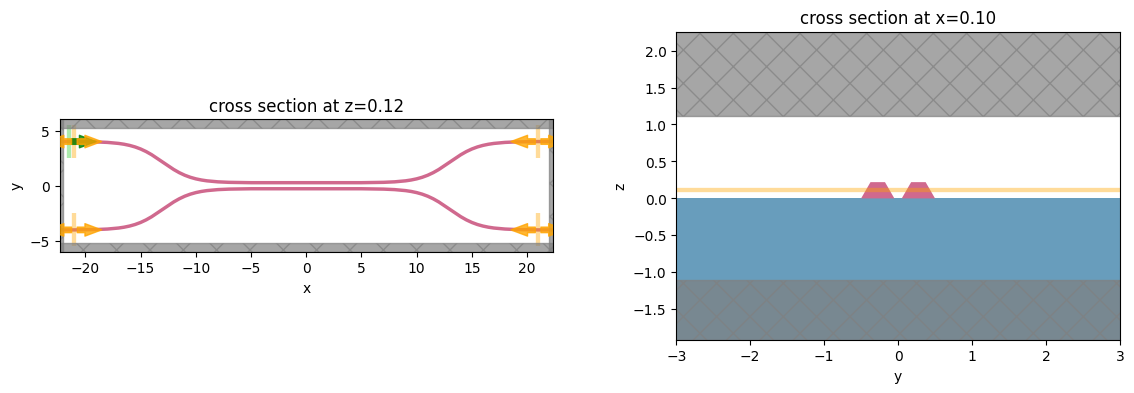

In [6]:
# visualize geometry
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sim.plot(z=wg_height / 2 + 0.01, ax=ax1)
sim.plot(x=0.1, ax=ax2)
ax2.set_xlim([-3, 3])
plt.show()


## Create and Submit Job

The [Job](../_autosummary/tidy3d.web.Job.html) object provides an interface for managing simulations.

`job = Job(simulation)` will create a job and upload the simulation to our server to run.

Then, one may call various methods of `job` to monitor progress, download results, and get information.

For more information, refer to the API reference.

In [7]:
# create job, upload sim to server to begin running
job = web.Job(simulation=sim, task_name="CouplerVerify", verbose=True)

# download the results and load them into a simulation
sim_data = job.run(path="data/sim_data.hdf5")


[15:01:45] Created task 'CouplerVerify' with task_id               ]8;id=497542;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=449235;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-6a6a4aaf-0e3f-4e42-a5df-337a4f65f4fcv1'.                       

           View task using web UI at                               ]8;id=469457;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=667196;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=745202;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a6a4aaf-0e3f-4e42-a5df-337a4f65f4fcv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=870622;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a6a4aaf-0e3f-4e42-a5df-337a4f65f4fcv1\taskId]8;;\]8;id=745202;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a6a4aaf-0e3f-4e42-a5df-337a4f65f4fcv1\=]8;;\]8;id=68190;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a6a4aaf-0e3f-4e42-a5df-337a4f65f4fcv1\fdve]8;;\]8;id=745202;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a6a4aaf-0e3f-4e42-a5df-337a4f65f4fcv1\-]8;;\              
           ]8;id=745202;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a6a4aaf-0e3f-4e42-a5df-337a4f65f4fcv1\6a6a4aaf-0e3f-4e42-a5df-337a4f65f4fcv1']8;;\.                             

Output()

[15:01:50] status = queued                                         ]8;id=564431;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=632023;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[15:02:15] status = preprocess                                     ]8;id=361898;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=572166;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[15:02:21] Maximum FlexCredit cost: 0.570. Use                     ]8;id=837746;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=520296;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=998173;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=419149;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=676272;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=631280;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=829463;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=162940;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[15:06:15] early shutoff detected, exiting.                        ]8;id=198651;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=368695;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=695890;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=175242;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#419\419]8;;\

Output()

[15:06:28] status = success                                        ]8;id=524556;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=920415;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#426\426]8;;\

Output()

[15:06:30] loading SimulationData from data/sim_data.hdf5          ]8;id=774269;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=539723;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\

## Postprocessing

The following function takes a completed simulation (with data loaded into it) and computes the quantities of interest.

For this case, we measure both the total transmission in the right ports and also the ratio of power between the top and bottom ports.

In [8]:
def measure_transmission(sim_data):
    """Constructs a "row" of the scattering matrix when sourced from top left port"""

    input_amp = sim_data["in"].amps.sel(direction="+")

    amps = np.zeros(4, dtype=complex)
    directions = ("-", "-", "+", "+")
    for i, (monitor, direction) in enumerate(
        zip(sim_data.simulation.monitors[:4], directions)
    ):
        amp = sim_data[monitor.name].amps.sel(direction=direction)
        amp_normalized = amp / input_amp
        amps[i] = np.squeeze(amp_normalized.values)

    return amps


In [9]:
# monitor and test out the measure_transmission function the results of the single run
amps_arms = measure_transmission(sim_data)
print("mode amplitudes in each port:\n")
for amp, monitor in zip(amps_arms, sim_data.simulation.monitors[:-1]):
    print(f'\tmonitor     = "{monitor.name}"')
    print(f"\tamplitude^2 = {abs(amp)**2:.2f}")
    print(f"\tphase       = {(np.angle(amp)):.2f} (rad)\n")


mode amplitudes in each port:

	monitor     = "in"
	amplitude^2 = 0.00
	phase       = -2.01 (rad)

	monitor     = "refect_bottom"
	amplitude^2 = 0.00
	phase       = 0.76 (rad)

	monitor     = "top"
	amplitude^2 = 0.95
	phase       = -0.37 (rad)

	monitor     = "bottom"
	amplitude^2 = 0.04
	phase       = 1.21 (rad)



[15:06:35] WARNING: 'freq' supplied to 'plot_field', frequency   ]8;id=125926;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/sim_data.py\sim_data.py]8;;\:]8;id=202114;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/sim_data.py#557\557]8;;\
           selection key renamed to 'f' and 'freq' will error in                
           future release, please update your local script to                   
           use 'f=value'.                                                       

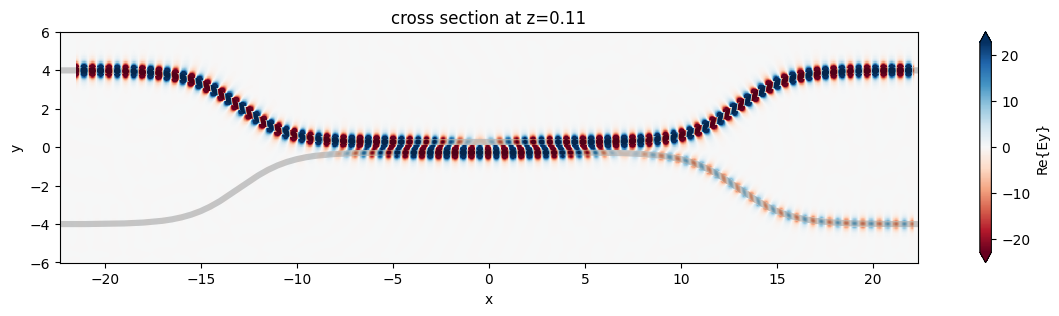

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
sim_data.plot_field("field", "Ey", z=wg_height / 2, freq=freq0, ax=ax)
plt.show()


## 1D Parameter Scan

Now we will scan through the coupling length parameter to see the effect on splitting ratio.

To do this, we will create a list of simulations corresponding to each parameter combination.

We will use this list to create a [Batch](../_autosummary/tidy3d.web.Batch.html) object, which has similar functionality to [Job](../_autosummary/tidy3d.web.Job.html) but allows one to manage a *set* of jobs.

First, we create arrays to store the input and output values.

In [11]:
# create variables to store parameters, simulation information, results
Nl = 11

ls = np.linspace(5, 12, Nl)
split_ratios = np.zeros(Nl)
efficiencies = np.zeros(Nl)


### Create Batch

We now create our list of simulations and use them to initialize a [Batch](../_autosummary/tidy3d.web.Batch.html).

For more information, refer to the API reference.

In [12]:
# submit all jobs
sims = {f"l={l:.2f}": make_sim(l, wg_spacing_coup) for l in ls}
batch = web.Batch(simulations=sims, verbose=True)


[15:06:38] Created task 'l=5.00' with task_id                      ]8;id=247088;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=43473;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-69eb89e8-776c-4dce-827c-0d35aa480d82v1'.                       

           View task using web UI at                               ]8;id=309238;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=61561;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=620152;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69eb89e8-776c-4dce-827c-0d35aa480d82v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=871147;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69eb89e8-776c-4dce-827c-0d35aa480d82v1\taskId]8;;\]8;id=620152;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69eb89e8-776c-4dce-827c-0d35aa480d82v1\=]8;;\]8;id=675653;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69eb89e8-776c-4dce-827c-0d35aa480d82v1\fdve]8;;\]8;id=620152;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69eb89e8-776c-4dce-827c-0d35aa480d82v1\-]8;;\              
           ]8;id=620152;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69eb89e8-776c-4dce-827c-0d35aa480d82v1\69eb89e8-776c-4dce-827c-0d35aa480d82v1']8;;\.                             

Output()

           Created task 'l=5.70' with task_id                      ]8;id=334280;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=73384;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-13acdb5c-4c52-4889-9627-e69818f4ddacv1'.                       

           View task using web UI at                               ]8;id=476356;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=493784;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=595619;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13acdb5c-4c52-4889-9627-e69818f4ddacv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=554325;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13acdb5c-4c52-4889-9627-e69818f4ddacv1\taskId]8;;\]8;id=595619;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13acdb5c-4c52-4889-9627-e69818f4ddacv1\=]8;;\]8;id=459735;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13acdb5c-4c52-4889-9627-e69818f4ddacv1\fdve]8;;\]8;id=595619;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13acdb5c-4c52-4889-9627-e69818f4ddacv1\-]8;;\              
           ]8;id=595619;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13acdb5c-4c52-4889-9627-e69818f4ddacv1\13acdb5c-4c52-4889-9627-e69818f4ddacv1']8;;\.                             

Output()

           Created task 'l=6.40' with task_id                      ]8;id=309526;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=81808;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-caae8dbb-2870-441c-83e0-c0e415f51fb9v1'.                       

           View task using web UI at                               ]8;id=954450;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=90645;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=701272;https://tidy3d.simulation.cloud/workbench?taskId=fdve-caae8dbb-2870-441c-83e0-c0e415f51fb9v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=54348;https://tidy3d.simulation.cloud/workbench?taskId=fdve-caae8dbb-2870-441c-83e0-c0e415f51fb9v1\taskId]8;;\]8;id=701272;https://tidy3d.simulation.cloud/workbench?taskId=fdve-caae8dbb-2870-441c-83e0-c0e415f51fb9v1\=]8;;\]8;id=836657;https://tidy3d.simulation.cloud/workbench?taskId=fdve-caae8dbb-2870-441c-83e0-c0e415f51fb9v1\fdve]8;;\]8;id=701272;https://tidy3d.simulation.cloud/workbench?taskId=fdve-caae8dbb-2870-441c-83e0-c0e415f51fb9v1\-]8;;\              
           ]8;id=701272;https://tidy3d.simulation.cloud/workbench?taskId=fdve-caae8dbb-2870-441c-83e0-c0e415f51fb9v1\caae8dbb-2870-441c-83e0-c0e415f51fb9v1']8;;\.                             

Output()

[15:06:39] Created task 'l=7.10' with task_id                      ]8;id=425485;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=633195;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-8cc10056-cc64-43f5-a2f5-3f25400c0e8av1'.                       

           View task using web UI at                               ]8;id=306077;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=73766;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=681919;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cc10056-cc64-43f5-a2f5-3f25400c0e8av1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=6790;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cc10056-cc64-43f5-a2f5-3f25400c0e8av1\taskId]8;;\]8;id=681919;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cc10056-cc64-43f5-a2f5-3f25400c0e8av1\=]8;;\]8;id=993891;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cc10056-cc64-43f5-a2f5-3f25400c0e8av1\fdve]8;;\]8;id=681919;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cc10056-cc64-43f5-a2f5-3f25400c0e8av1\-]8;;\              
           ]8;id=681919;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cc10056-cc64-43f5-a2f5-3f25400c0e8av1\8cc10056-cc64-43f5-a2f5-3f25400c0e8av1']8;;\.                             

Output()

           Created task 'l=7.80' with task_id                      ]8;id=970638;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=236056;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-fdbfba0f-31e1-4434-a691-facbdbfb601ev1'.                       

           View task using web UI at                               ]8;id=115649;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=630596;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=400636;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fdbfba0f-31e1-4434-a691-facbdbfb601ev1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=273335;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fdbfba0f-31e1-4434-a691-facbdbfb601ev1\taskId]8;;\]8;id=400636;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fdbfba0f-31e1-4434-a691-facbdbfb601ev1\=]8;;\]8;id=788075;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fdbfba0f-31e1-4434-a691-facbdbfb601ev1\fdve]8;;\]8;id=400636;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fdbfba0f-31e1-4434-a691-facbdbfb601ev1\-]8;;\              
           ]8;id=400636;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fdbfba0f-31e1-4434-a691-facbdbfb601ev1\fdbfba0f-31e1-4434-a691-facbdbfb601ev1']8;;\.                             

Output()

[15:06:40] Created task 'l=8.50' with task_id                      ]8;id=526722;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=474321;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-6b8175d1-6eef-479a-aea2-212097b3faadv1'.                       

           View task using web UI at                               ]8;id=473165;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=160353;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=594064;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8175d1-6eef-479a-aea2-212097b3faadv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=748949;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8175d1-6eef-479a-aea2-212097b3faadv1\taskId]8;;\]8;id=594064;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8175d1-6eef-479a-aea2-212097b3faadv1\=]8;;\]8;id=668902;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8175d1-6eef-479a-aea2-212097b3faadv1\fdve]8;;\]8;id=594064;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8175d1-6eef-479a-aea2-212097b3faadv1\-]8;;\              
           ]8;id=594064;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8175d1-6eef-479a-aea2-212097b3faadv1\6b8175d1-6eef-479a-aea2-212097b3faadv1']8;;\.                             

Output()

           Created task 'l=9.20' with task_id                      ]8;id=841886;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=117673;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-b38f45aa-52f9-4f4f-919f-0acd5d4644c5v1'.                       

           View task using web UI at                               ]8;id=762538;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=957110;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=729899;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b38f45aa-52f9-4f4f-919f-0acd5d4644c5v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=825065;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b38f45aa-52f9-4f4f-919f-0acd5d4644c5v1\taskId]8;;\]8;id=729899;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b38f45aa-52f9-4f4f-919f-0acd5d4644c5v1\=]8;;\]8;id=220649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b38f45aa-52f9-4f4f-919f-0acd5d4644c5v1\fdve]8;;\]8;id=729899;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b38f45aa-52f9-4f4f-919f-0acd5d4644c5v1\-]8;;\              
           ]8;id=729899;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b38f45aa-52f9-4f4f-919f-0acd5d4644c5v1\b38f45aa-52f9-4f4f-919f-0acd5d4644c5v1']8;;\.                             

Output()

[15:06:41] Created task 'l=9.90' with task_id                      ]8;id=297655;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=932105;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-0823938f-e9f7-4f9d-bf46-2dbb5ab3b525v1'.                       

           View task using web UI at                               ]8;id=495249;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=933613;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=109025;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0823938f-e9f7-4f9d-bf46-2dbb5ab3b525v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=320933;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0823938f-e9f7-4f9d-bf46-2dbb5ab3b525v1\taskId]8;;\]8;id=109025;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0823938f-e9f7-4f9d-bf46-2dbb5ab3b525v1\=]8;;\]8;id=986222;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0823938f-e9f7-4f9d-bf46-2dbb5ab3b525v1\fdve]8;;\]8;id=109025;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0823938f-e9f7-4f9d-bf46-2dbb5ab3b525v1\-]8;;\              
           ]8;id=109025;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0823938f-e9f7-4f9d-bf46-2dbb5ab3b525v1\0823938f-e9f7-4f9d-bf46-2dbb5ab3b525v1']8;;\.                             

Output()

           Created task 'l=10.60' with task_id                     ]8;id=181886;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=551309;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-97bc1667-f738-4a63-8e2f-2bf157dea454v1'.                       

           View task using web UI at                               ]8;id=581127;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=650908;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=850207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bc1667-f738-4a63-8e2f-2bf157dea454v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=830167;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bc1667-f738-4a63-8e2f-2bf157dea454v1\taskId]8;;\]8;id=850207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bc1667-f738-4a63-8e2f-2bf157dea454v1\=]8;;\]8;id=401148;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bc1667-f738-4a63-8e2f-2bf157dea454v1\fdve]8;;\]8;id=850207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bc1667-f738-4a63-8e2f-2bf157dea454v1\-]8;;\              
           ]8;id=850207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bc1667-f738-4a63-8e2f-2bf157dea454v1\97bc1667-f738-4a63-8e2f-2bf157dea454v1']8;;\.                             

Output()

           Created task 'l=11.30' with task_id                     ]8;id=840938;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=363931;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-f96e5f6c-6a33-4669-987e-21404208ac42v1'.                       

           View task using web UI at                               ]8;id=139872;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=11571;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=237347;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f96e5f6c-6a33-4669-987e-21404208ac42v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=700117;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f96e5f6c-6a33-4669-987e-21404208ac42v1\taskId]8;;\]8;id=237347;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f96e5f6c-6a33-4669-987e-21404208ac42v1\=]8;;\]8;id=411914;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f96e5f6c-6a33-4669-987e-21404208ac42v1\fdve]8;;\]8;id=237347;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f96e5f6c-6a33-4669-987e-21404208ac42v1\-]8;;\              
           ]8;id=237347;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f96e5f6c-6a33-4669-987e-21404208ac42v1\f96e5f6c-6a33-4669-987e-21404208ac42v1']8;;\.                             

Output()

[15:06:42] Created task 'l=12.00' with task_id                     ]8;id=787337;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=513291;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-b4b993ba-d877-48f5-a40c-f5a2dcdff585v1'.                       

           View task using web UI at                               ]8;id=942089;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=215526;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=432755;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b993ba-d877-48f5-a40c-f5a2dcdff585v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=665149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b993ba-d877-48f5-a40c-f5a2dcdff585v1\taskId]8;;\]8;id=432755;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b993ba-d877-48f5-a40c-f5a2dcdff585v1\=]8;;\]8;id=194832;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b993ba-d877-48f5-a40c-f5a2dcdff585v1\fdve]8;;\]8;id=432755;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b993ba-d877-48f5-a40c-f5a2dcdff585v1\-]8;;\              
           ]8;id=432755;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b993ba-d877-48f5-a40c-f5a2dcdff585v1\b4b993ba-d877-48f5-a40c-f5a2dcdff585v1']8;;\.                             

Output()

### Monitor Batch

Here we can perform real-time monitoring of how many of the jobs in the batch have completed.

In [13]:
batch_results = batch.run(path_dir="data")


[15:06:46] Started working on Batch.                            ]8;id=565433;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=982265;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#475\475]8;;\

[15:08:16] Maximum FlexCredit cost: 6.043 for the whole batch.  ]8;id=834016;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=189266;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#479\479]8;;\
           Use 'Batch.real_cost()' to get the billed FlexCredit                 
           cost after the Batch has completed.                                  

Output()

[15:15:14] Batch complete.                                      ]8;id=51545;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=797290;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#522\522]8;;\

### Load and visualize Results

Finally, we can compute the output quantities and load them into the arrays we created initally.

Then we may plot the results.

In [14]:
amps_batch = []
for task_name, sim_data in batch_results.items():
    amps_arms_i = np.array(measure_transmission(sim_data))
    amps_batch.append(amps_arms_i)
amps_batch = np.stack(amps_batch, axis=1)
print(amps_batch.shape)  # (4, Nl)
print(amps_batch)


Output()

[15:15:23] loading SimulationData from                             ]8;id=686941;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=449003;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-69eb89e8-776c-4dce-827c-0d35aa480d82v1.hdf5                

Output()

           loading SimulationData from                             ]8;id=786957;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=12630;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-13acdb5c-4c52-4889-9627-e69818f4ddacv1.hdf5                

Output()

[15:15:24] loading SimulationData from                             ]8;id=277915;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=697054;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-caae8dbb-2870-441c-83e0-c0e415f51fb9v1.hdf5                

Output()

           loading SimulationData from                             ]8;id=737746;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=540799;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-8cc10056-cc64-43f5-a2f5-3f25400c0e8av1.hdf5                

Output()

[15:15:25] loading SimulationData from                             ]8;id=699184;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=238118;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-fdbfba0f-31e1-4434-a691-facbdbfb601ev1.hdf5                

Output()

           loading SimulationData from                             ]8;id=292743;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=164858;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-6b8175d1-6eef-479a-aea2-212097b3faadv1.hdf5                

Output()

[15:15:26] loading SimulationData from                             ]8;id=102875;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=82850;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-b38f45aa-52f9-4f4f-919f-0acd5d4644c5v1.hdf5                

Output()

           loading SimulationData from                             ]8;id=233708;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=214639;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-0823938f-e9f7-4f9d-bf46-2dbb5ab3b525v1.hdf5                

Output()

[15:15:27] loading SimulationData from                             ]8;id=509891;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=590754;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-97bc1667-f738-4a63-8e2f-2bf157dea454v1.hdf5                

Output()

           loading SimulationData from                             ]8;id=550974;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=876312;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-f96e5f6c-6a33-4669-987e-21404208ac42v1.hdf5                

Output()

[15:15:28] loading SimulationData from                             ]8;id=960358;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=655302;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-b4b993ba-d877-48f5-a40c-f5a2dcdff585v1.hdf5                

(4, 11)
[[-6.88328582e-03+1.61097985e-04j  2.80601686e-03-3.25849150e-03j
  -6.05509566e-03-1.35832292e-03j -2.35873108e-05+3.26387865e-03j
  -2.64588040e-03-1.04148956e-02j -3.92476393e-03+3.56056787e-03j
   7.25422545e-04-4.00450689e-03j -4.50164084e-03-8.15485086e-04j
   6.44835459e-04-2.07264079e-03j -4.68472176e-03-1.09922315e-03j
   3.99251267e-04+2.27877669e-03j]
 [ 7.60741345e-03-1.41931692e-03j -3.56043783e-03+3.17863084e-03j
   2.74562240e-03+2.55029562e-03j  1.24389995e-03+9.01929734e-04j
   1.17298323e-03+8.00084207e-03j  2.06996568e-03-2.68642935e-03j
  -1.63113792e-03+8.07277873e-03j  4.17569213e-03-1.16746889e-03j
  -2.49209864e-03+2.07818474e-03j  2.59925680e-03+7.49681092e-03j
  -4.69108686e-04-3.79585307e-03j]
 [ 4.47001453e-01+4.22381947e-01j  6.76803830e-01-2.61152901e-01j
   2.86672928e-02-8.19183849e-01j -8.13009154e-01-3.75187755e-01j
  -7.02815270e-01+6.40098544e-01j  3.28939817e-01+9.27131999e-01j
   9.91166533e-01+6.25283820e-02j  4.60598441e-01-8.64562228e-01

In [15]:
powers = abs(amps_batch) ** 2
power_top = powers[2]
power_bot = powers[3]
power_out = power_top + power_bot


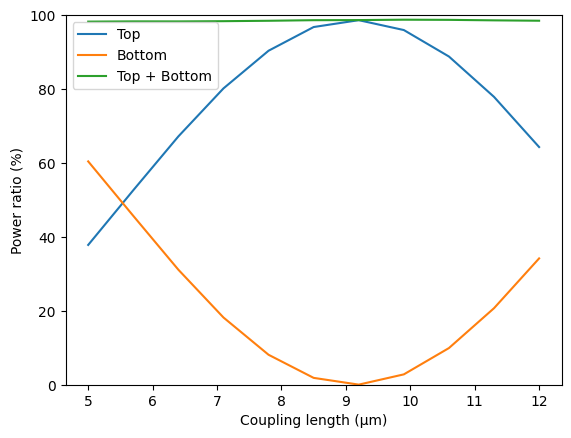

In [16]:
plt.plot(ls, 100 * power_top, label="Top")
plt.plot(ls, 100 * power_bot, label="Bottom")
plt.plot(ls, 100 * power_out, label="Top + Bottom")
plt.xlabel("Coupling length (µm)")
plt.ylabel("Power ratio (%)")
plt.ylim(0, 100)
plt.legend()
plt.show()


### Final Remarks

Batches provide some other convenient functionality for managing large numbers of jobs.

For example, one can save the batch information to file and load the batch at a later time, if needing to disconnect from the service while the jobs are running.

In [17]:
# save batch metadata
batch.to_file("data/batch_data.json")

# load batch metadata into a new batch
loaded_batch = web.Batch.from_file("data/batch_data.json")


For more reference, refer to our documentation.